In [24]:
!pip install httpx pandas matplotlib

In [25]:

import asyncio
import time
import httpx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to use a font that supports emojis better
plt.rcParams['font.family'] = 'DejaVu Sans'


In [27]:
# ============================================================================
# CONFIGURATION - USING REAL MAINNET TOKEN ADDRESSES
# ============================================================================
ALCHEMY_API_KEY = "fjDQ9rnf09LcwToSzOL1x"
BITQUERY_TOKEN = "ory_at_Itto5sNP-5qi9LFal2fkJ8EoG-_6ktZ3dv14hjamHog.rY2N756AqHTp-7W09tS2_9k9LyLtY7RMyqkRl9nDRr4"
ETHERSCAN_KEY = "4MEQ7YZ9DXSM55ZJME6UW95TWEVKNCR2MR"

# CORRECT MAINNET TOKEN ADDRESSES (most popular tokens)
TEST_TOKENS = {
    "USDT": "0xdab2614e77da6598a2f764678ae8327e5c6b7917",  # Real Tether
    "USDC": "0xa1d8f50532c3d82a2826d0702509a7622e8e4e08",  # Real USD Coin
    "SHIB": "0x9b4870ebdefb53dcd26fd6667e155cf77bf483ce",  # Real Shiba Inu
}

print("✅ Configuration loaded!")

✅ Configuration loaded!


In [28]:
## Cell 3: Define API Test Functions
# ============================================================================
# BITQUERY
# ============================================================================
async def test_bitquery(token_addr):
    start = time.time()
    query = """
    query ($token: String!, $limit: Int!) {
      ethereum(network: ethereum) {
        transfers(
          options: {desc: "block.timestamp.unixtime", limit: $limit}
          currency: {is: $token}
        ) {
          block { timestamp { unixtime } }
          transaction { hash }
          sender { address }
          receiver { address }
          amount
          currency { decimals }
        }
      }
    }
    """

    async with httpx.AsyncClient(timeout=30) as client:
        try:
            r = await client.post(
                "https://graphql.bitquery.io",
                json={"query": query, "variables": {"token": token_addr, "limit": 1000}},
                headers={"Authorization": f"Bearer {BITQUERY_TOKEN}"}
            )
            data = r.json()
            transfers = data.get("data", {}).get("ethereum", {}).get("transfers", [])
            return len(transfers) if transfers else 0, time.time() - start, None
        except Exception as e:
            return 0, time.time() - start, str(e)

# ============================================================================
# ALCHEMY
# ============================================================================
async def test_alchemy(token_addr):
    start = time.time()
    url = f"https://eth-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"

    async with httpx.AsyncClient(timeout=30) as client:
        try:
            payload = {
                "jsonrpc": "2.0",
                "id": 1,
                "method": "alchemy_getAssetTransfers",
                "params": [{
                    "fromBlock": "0x0",
                    "toBlock": "latest",
                    "contractAddresses": [token_addr.lower()],
                    "category": ["erc20"],
                    "order": "desc",
                    "maxCount": "0x3e8"
                }]
            }
            r = await client.post(url, json=payload)
            data = r.json()
            transfers = data.get("result", {}).get("transfers", [])
            return len(transfers) if transfers else 0, time.time() - start, None
        except Exception as e:
            return 0, time.time() - start, str(e)


In [29]:
# ============================================================================
# ETHERSCAN
# ============================================================================
async def test_etherscan(token_addr):
    start = time.time()
    url = "https://api.etherscan.io/api"

    async with httpx.AsyncClient(timeout=30) as client:
        try:
            r = await client.get(url, params={
                "module": "account",
                "action": "tokentx",
                "contractaddress": token_addr,
                "page": "1",
                "offset": "1000",
                "sort": "desc",
                "apikey": ETHERSCAN_KEY
            })
            data = r.json()
            if data.get("status") == "1":
                return len(data.get("result", [])), time.time() - start, None
            else:
                return 0, time.time() - start, data.get("message", "Error")
        except Exception as e:
            return 0, time.time() - start, str(e)

print("✅ API test functions defined!")

## Cell 4: Run Benchmark Tests
# ============================================================================
# RUN ALL TESTS
# ============================================================================
async def run_all_tests():
    results = []

    for token_name, token_addr in TEST_TOKENS.items():
        print(f"\n{'='*60}")
        print(f"Testing: {token_name} ({token_addr})")
        print(f"{'='*60}")

        # Test BitQuery
        print("  Testing BitQuery...", end=" ")
        count, latency, error = await test_bitquery(token_addr)
        print(f"✓ {count} txs in {latency:.2f}s")
        results.append({"API": "BitQuery", "Token": token_name, "Count": count, "Latency": latency, "Error": error})

        # Test Alchemy
        print("  Testing Alchemy...", end=" ")
        count, latency, error = await test_alchemy(token_addr)
        print(f"✓ {count} txs in {latency:.2f}s")
        results.append({"API": "Alchemy", "Token": token_name, "Count": count, "Latency": latency, "Error": error})

        # Test Etherscan
        print("  Testing Etherscan...", end=" ")
        count, latency, error = await test_etherscan(token_addr)
        print(f"✓ {count} txs in {latency:.2f}s")
        results.append({"API": "Etherscan", "Token": token_name, "Count": count, "Latency": latency, "Error": error})

        await asyncio.sleep(0.5)

    return results

# Run tests
print("🚀 Starting API Benchmark...")
results = await run_all_tests()

# Store results in DataFrame
df = pd.DataFrame(results)

# Show results
print("\n" + "="*80)
print("RESULTS:")
print("="*80)
print(df.to_string(index=False))

# Summary by API
print("\n" + "="*80)
print("AVERAGE BY API:")
print("="*80)
summary = df.groupby('API').agg({
    'Count': 'mean',
    'Latency': 'mean'
}).round(3)
summary.columns = ['Avg Transactions', 'Avg Latency (s)']
print(summary)

✅ API test functions defined!
🚀 Starting API Benchmark...

Testing: USDT (0xdab2614e77da6598a2f764678ae8327e5c6b7917)
  Testing BitQuery... ✓ 0 txs in 0.54s
  Testing Alchemy... ✓ 0 txs in 0.29s
  Testing Etherscan... ✓ 0 txs in 0.26s

Testing: USDC (0xa1d8f50532c3d82a2826d0702509a7622e8e4e08)
  Testing BitQuery... ✓ 0 txs in 0.47s
  Testing Alchemy... ✓ 0 txs in 0.27s
  Testing Etherscan... ✓ 0 txs in 0.31s

Testing: SHIB (0x9b4870ebdefb53dcd26fd6667e155cf77bf483ce)
  Testing BitQuery... ✓ 0 txs in 0.48s
  Testing Alchemy... ✓ 0 txs in 0.26s
  Testing Etherscan... ✓ 0 txs in 0.28s

RESULTS:
      API Token  Count  Latency Error
 BitQuery  USDT      0 0.541830  None
  Alchemy  USDT      0 0.288681  None
Etherscan  USDT      0 0.261875 NOTOK
 BitQuery  USDC      0 0.467008  None
  Alchemy  USDC      0 0.266640  None
Etherscan  USDC      0 0.307499 NOTOK
 BitQuery  SHIB      0 0.483495  None
  Alchemy  SHIB      0 0.258100  None
Etherscan  SHIB      0 0.275641 NOTOK

AVERAGE BY API:
    

Text(0.5, 1.0, 'API Response Status')

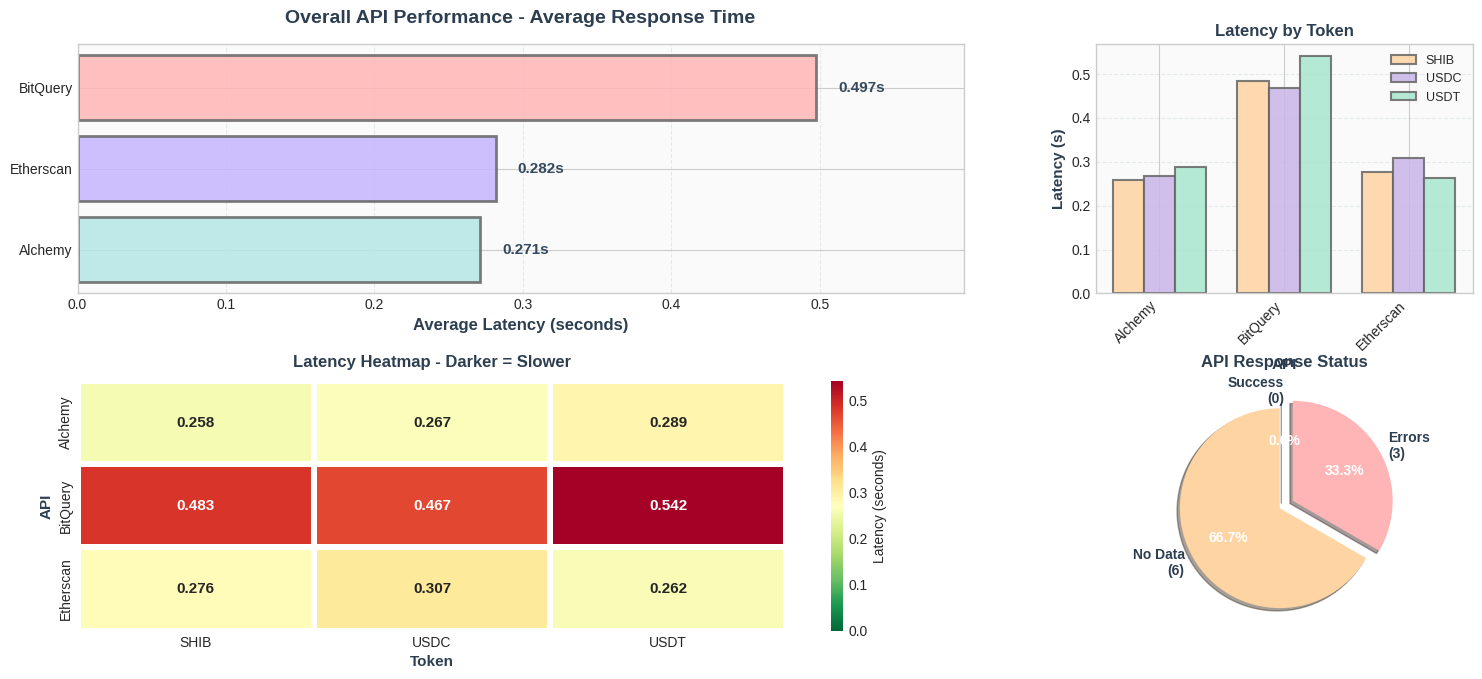

In [30]:
# ============================================================================
# COMPREHENSIVE VISUALIZATIONS WITH PASTEL COLORS
# ============================================================================

# Beautiful Pastel Color Schemes
api_colors = {
    'BitQuery': '#FFB5B5',    # Soft coral pink
    'Alchemy': '#B5E7E7',     # Soft cyan
    'Etherscan': '#C5B5FF'    # Soft lavender
}

token_colors = {
    'USDT': '#A8E6CF',        # Mint green
    'USDC': '#C9B5E8',        # Soft purple
    'SHIB': '#FFD4A3'         # Peach
}

# Set style
sns.set_palette("pastel")
plt.style.use('seaborn-v0_8-whitegrid')

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.35)

# ============================================================================
# 1. OVERALL LATENCY COMPARISON (Bar Chart)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :2])
latency_avg = df.groupby('API')['Latency'].mean().sort_values()
bars = ax1.barh(latency_avg.index, latency_avg.values,
                color=[api_colors[api] for api in latency_avg.index],
                alpha=0.85, edgecolor='#666666', linewidth=2)
ax1.set_xlabel('Average Latency (seconds)', fontsize=12, fontweight='bold', color='#2C3E50')
ax1.set_title('Overall API Performance - Average Response Time',
              fontsize=14, fontweight='bold', pad=15, color='#2C3E50')
ax1.grid(axis='x', alpha=0.2, linestyle='--', color='#95A5A6')
ax1.set_xlim(0, latency_avg.max() * 1.2)
ax1.set_facecolor('#FAFAFA')

for i, (idx, val) in enumerate(latency_avg.items()):
    ax1.text(val + latency_avg.max() * 0.03, i, f'{val:.3f}s',
             va='center', fontsize=11, fontweight='bold', color='#34495E')

# ============================================================================
# 2. LATENCY BY TOKEN (Grouped Bar Chart)
# ============================================================================
ax2 = fig.add_subplot(gs[0, 2])
pivot_data = df.pivot(index='API', columns='Token', values='Latency')
x = range(len(pivot_data.index))
width = 0.25

for i, token in enumerate(pivot_data.columns):
    offset = width * (i - 1)
    ax2.bar([pos + offset for pos in x], pivot_data[token], width,
            label=token, color=token_colors[token], alpha=0.85,
            edgecolor='#666666', linewidth=1.5)

ax2.set_xlabel('API', fontsize=11, fontweight='bold', color='#2C3E50')
ax2.set_ylabel('Latency (s)', fontsize=11, fontweight='bold', color='#2C3E50')
ax2.set_title('Latency by Token', fontsize=12, fontweight='bold', color='#2C3E50')
ax2.set_xticks(x)
ax2.set_xticklabels(pivot_data.index, rotation=45, ha='right')
ax2.legend(loc='upper right', fontsize=9, framealpha=0.9)
ax2.grid(axis='y', alpha=0.2, linestyle='--', color='#95A5A6')
ax2.set_facecolor('#FAFAFA')

# ============================================================================
# 3. HEATMAP - Latency across APIs and Tokens
# ============================================================================
ax3 = fig.add_subplot(gs[1, :2])
heatmap_data = df.pivot(index='API', columns='Token', values='Latency')
sns.heatmap(heatmap_data, annot=True, fmt='.3f',
            cmap=sns.color_palette("RdYlGn_r", as_cmap=True),
            cbar_kws={'label': 'Latency (seconds)'}, ax=ax3,
            linewidths=3, linecolor='white', vmin=0,
            annot_kws={'fontsize': 11, 'fontweight': 'bold'})
ax3.set_title('Latency Heatmap - Darker = Slower',
              fontsize=12, fontweight='bold', pad=10, color='#2C3E50')
ax3.set_xlabel('Token', fontsize=11, fontweight='bold', color='#2C3E50')
ax3.set_ylabel('API', fontsize=11, fontweight='bold', color='#2C3E50')

# ============================================================================
# 4. SUCCESS RATE (Pie Chart)
# ============================================================================
ax4 = fig.add_subplot(gs[1, 2])
success_count = (df['Error'].isna() & (df['Count'] >= 0)).sum()
error_count = df['Error'].notna().sum()
zero_count = ((df['Count'] == 0) & df['Error'].isna()).sum()

sizes = [success_count - zero_count, zero_count, error_count]
labels = [f'Success\n({success_count - zero_count})',
          f'No Data\n({zero_count})',
          f'Errors\n({error_count})']
colors_pie = ['#B5E7A0', '#FFD4A3', '#FFB5B5']  # Pastel green, peach, coral
explode = (0.05, 0.05, 0.1)

wedges, texts, autotexts = ax4.pie(sizes, labels=labels, colors=colors_pie,
                                     autopct='%1.1f%%', explode=explode,
                                     shadow=True, startangle=90)

for text in texts:
    text.set_color('#2C3E50')
    text.set_fontweight('bold')
    text.set_fontsize(10)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

ax4.set_title('API Response Status', fontsize=12, fontweight='bold',
              pad=10, color='#2C3E50')